In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import scale
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split

import hervpd as hp
import plotReport as pr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Data description

In [10]:
df = pd.read_excel('/home/ju/GDrive/Projects/HeRV/Data/PreProcessed/df.xlsx')
df.describe()

,hf,hfnu,lf,lf_hf,lfnu,mhr,mrri,nn50,order,pnn50,rmssd,sdnn,sess,total_power,user,vlf
count,2.619000e+03,2619.000000,2.619000e+03,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2.619000e+03,2619.000000,2.619000e+03
mean,2.372505e+04,45.385168,4.309845e+05,2.519038,54.614832,80.316212,796.870991,86.230241,20.298205,24.345589,108.754669,111.438615,156.244750,1.508606e+06,1.623139,1.053896e+06
std,1.840094e+05,23.096016,9.142996e+06,4.950977,23.096016,17.318303,159.679709,73.326207,26.599498,23.015230,161.561323,115.954166,112.334309,4.655677e+07,1.996276,3.761767e+07
min,5.751146e-01,1.419545,2.567078e+00,0.027289,2.656368,47.596407,334.157205,0.000000,0.000000,0.000000,3.369205,13.625541,0.000000,3.390064e+01,0.000000,2.559104e+01
25%,3.264626e+02,26.230275,5.400063e+02,0.578918,36.665480,69.039105,698.960529,25.000000,2.000000,5.745437,30.572893,52.117072,59.000000,1.581253e+03,0.000000,4.772655e+02
50%,8.455907e+02,43.023321,1.209224e+03,1.324321,56.976679,78.705970,776.071066,66.000000,7.000000,16.745283,51.264944,74.884477,126.000000,3.291579e+03,1.000000,1.019906e+03
75%,4.492113e+03,63.334520,2.840573e+03,2.812395,73.769725,87.632704,890.307246,135.000000,30.000000,37.317784,131.050687,134.858549,289.500000,1.156531e+04,3.000000,2.341619e+03
max,6.139868e+06,97.343632,4.263838e+08,69.445109,98.580455,180.176325,1269.037344,354.000000,113.000000,91.726619,2239.263240,1776.464653,328.000000,2.338062e+09,6.000000,1.905538e+09


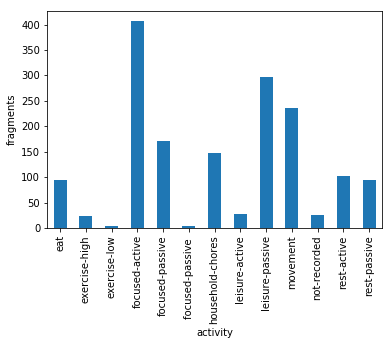

In [12]:
hp.plot_count(df, 'activity', exclude=['sleep'])

## 2A. Data preparation - Inserting labels for aggregating categories:

* 1: move vs still = exercise (high and low intensity), movement, household chores X *others*
* 2: sleep vs awake =  sleep X *others*
* 3: move vs sleep vs stand = Move (from 1) X Sleep (from 2) X *others*


In [14]:
movelist = ['exercise-high', 'exercise-low', 'movement', 'household-chores']
df = hp.add_partition(df, movelist, pname='move', labelIn='move', labelOut='still')
    
sleeplist = ['sleep']
df = hp.add_partition(df, sleeplist, pname='sleep', labelIn='sleep', labelOut='wake')

df.sample(5)

,activity,hf,hfnu,lf,lf_hf,lfnu,mhr,mrri,nn50,order,...,rmssd,sdnn,sess,start,stop,total_power,user,vlf,move,sleep
2593,sleep,1835.186801,47.938998,1992.984187,1.085984,52.061002,60.752748,1015.910596,131,88,...,76.470393,156.098982,326,2017-12-31 10:02:10,2017-12-31 10:07:10,12241.695482,6,8413.524494,still,sleep
2521,sleep,1928.833231,44.356955,2419.601463,1.254438,55.643045,66.143998,919.528529,146,1,...,77.058263,103.858554,326,2017-12-31 02:47:10,2017-12-31 02:52:10,7685.024228,6,3336.589534,still,sleep
100,household-chores,8551.578483,31.602869,18507.921835,2.164270,68.397131,101.425206,611.322645,49,0,...,190.083421,152.003349,7,2017-10-14 12:25:21,2017-10-14 12:30:21,34870.972096,0,7811.471778,move,wake
963,sleep,23793.425220,83.277658,4777.773416,0.200802,16.722342,59.031095,1119.644689,232,79,...,252.675623,258.899726,78,2017-09-30 07:14:14,2017-09-30 07:19:14,37215.253880,0,8644.055244,still,sleep
2292,rest-passive,2262.157311,59.263667,1554.949258,0.687375,40.736333,70.121778,883.872832,30,0,...,107.383965,104.536803,311,2017-12-29 13:41:01,2017-12-29 13:46:01,4474.459126,5,657.352557,still,wake


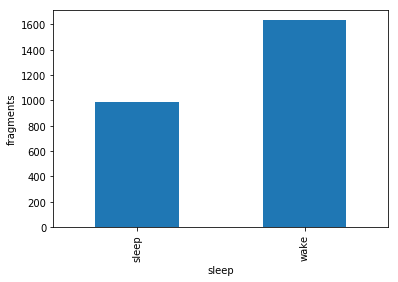

In [15]:
hp.plot_count(df, 'sleep')

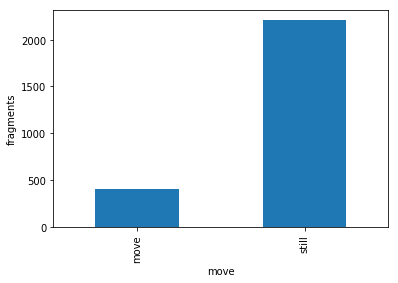

In [16]:
hp.plot_count(df, 'move')

## 2B. Data preparation - scaling and splitting test and train datasets

In [17]:
feature_list = ['hf', 'hfnu', 'lf', 'lf_hf', 'lfnu', 'mhr', 'mrri', 'nn50', 'hf', 'pnn50', 'rmssd', 'sdnn', 'total_power', 'vlf']
df[feature_list] = hp.scaled_features(df, feature_list)
df.describe()

,hf,hfnu,lf,lf_hf,lfnu,mhr,mrri,nn50,order,pnn50,rmssd,sdnn,sess,total_power,user,vlf
count,2.619000e+03,2.619000e+03,2.619000e+03,2.619000e+03,2.619000e+03,2.619000e+03,2.619000e+03,2.619000e+03,2619.000000,2.619000e+03,2.619000e+03,2.619000e+03,2619.000000,2.619000e+03,2619.000000,2.619000e+03
mean,2.967377e-19,-1.344646e-16,1.545156e-17,-1.848252e-17,-2.349315e-16,-1.448504e-16,-8.817350e-17,1.096531e-15,20.298205,4.161959e-16,1.483689e-16,2.406119e-16,156.244750,-2.835435e-17,1.623139,1.355323e-17
std,1.000191e+00,1.000191e+00,1.000191e+00,1.000191e+00,1.000191e+00,1.000191e+00,1.000191e+00,1.000191e+00,26.599498,1.000191e+00,1.000191e+00,1.000191e+00,112.334309,1.000191e+00,1.996276,1.000191e+00
min,-1.289554e-01,-1.903966e+00,-4.714694e-02,-5.033805e-01,-2.250102e+00,-1.889680e+00,-2.898315e+00,-1.176206e+00,0.000000,-1.058005e+00,-6.524185e-01,-8.437105e-01,0.000000,-3.240903e-02,0.000000,-2.802065e-02
25%,-1.271840e-01,-8.295176e-01,-4.708814e-02,-3.919409e-01,-7.773106e-01,-6.512914e-01,-6.132849e-01,-8.351984e-01,2.000000,-8.083214e-01,-4.840063e-01,-5.116924e-01,59.000000,-3.237579e-02,0.000000,-2.800864e-02
50%,-1.243623e-01,-1.022816e-01,-4.701493e-02,-2.413555e-01,1.022816e-01,-9.299699e-02,-1.302852e-01,-2.759464e-01,7.000000,-3.302925e-01,-3.559064e-01,-3.153066e-01,126.000000,-3.233904e-02,1.000000,-2.799421e-02
75%,-1.045414e-01,7.773106e-01,-4.683647e-02,5.926376e-02,8.295176e-01,4.225523e-01,5.852597e-01,6.652338e-01,30.000000,5.637429e-01,1.380298e-01,2.020144e-01,289.500000,-3.216130e-02,3.000000,-2.795907e-02
max,3.324456e+01,2.250102e+00,4.659678e+01,1.352033e+01,1.903966e+00,5.767261e+00,2.957524e+00,3.652458e+00,113.000000,2.928230e+00,1.318951e+01,1.436209e+01,328.000000,5.019676e+01,6.000000,5.063705e+01


In [18]:
train, test = train_test_split(df, test_size=0.2)
print (len(train), len(test))

2095 524


## 3. SVM classification - Moving vs still (including sleep in still activities)

### 3A. For all users combined

2095 train examples and 524 test examples
Best params for linear kernel: {'C': 100.0} with score 0.86038
--- test results for linear kernel:
             precision    recall  f1-score   support

       move       0.84      0.31      0.46        83
      still       0.88      0.99      0.93       441

avg / total       0.88      0.88      0.86       524

Best params for RBF kernel: {'C': 100.0, 'gamma': 0.10000000000000001} with score 0.88842
--- test results for RBF kernel:
             precision    recall  f1-score   support

       move       0.79      0.51      0.62        83
      still       0.91      0.98      0.94       441

avg / total       0.89      0.90      0.89       524

[0.79, 0.51, 0.62]
[0.91, 0.98, 0.94]


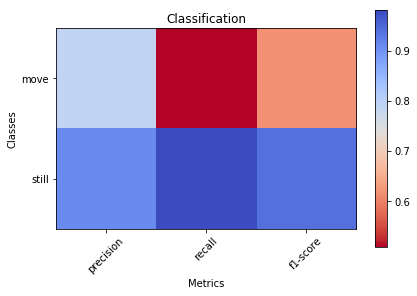

In [19]:
r = hp.run_flow(df, feature_list, labelName= 'move')
pr.plot_classification_report(r[1], cmap=plt.cm.coolwarm_r)

### 3B. For each user (SVM moving x still)

In [20]:
for user in [0,1,2,3,5]:
    r = hp.run_flow(df.loc[df.user == user], feature_list, labelName= 'move')

1028 train examples and 258 test examples
Best params for linear kernel: {'C': 100.0} with score 0.90534
--- test results for linear kernel:
             precision    recall  f1-score   support

       move       0.68      0.86      0.76        44
      still       0.97      0.92      0.94       214

avg / total       0.92      0.91      0.91       258

Best params for RBF kernel: {'C': 100.0, 'gamma': 0.10000000000000001} with score 0.91383
--- test results for RBF kernel:
             precision    recall  f1-score   support

       move       0.66      0.86      0.75        44
      still       0.97      0.91      0.94       214

avg / total       0.92      0.90      0.90       258

174 train examples and 44 test examples
Best params for linear kernel: {'C': 10.0} with score 0.99286
--- test results for linear kernel:
             precision    recall  f1-score   support

       move       1.00      1.00      1.00         2
      still       1.00      1.00      1.00        42

avg / t

## 4. SVM classification - Awake vs Sleep


### 4A. For all users combined

2095 train examples and 524 test examples
Best params for linear kernel: {'C': 100.0} with score 0.81444
--- test results for linear kernel:
             precision    recall  f1-score   support

      sleep       0.80      0.75      0.77       197
       wake       0.85      0.89      0.87       327

avg / total       0.83      0.83      0.83       524

Best params for RBF kernel: {'C': 1.0, 'gamma': 1.0} with score 0.87411
--- test results for RBF kernel:
             precision    recall  f1-score   support

      sleep       0.88      0.78      0.83       197
       wake       0.88      0.93      0.90       327

avg / total       0.88      0.88      0.87       524

[0.88, 0.78, 0.83]
[0.88, 0.93, 0.9]


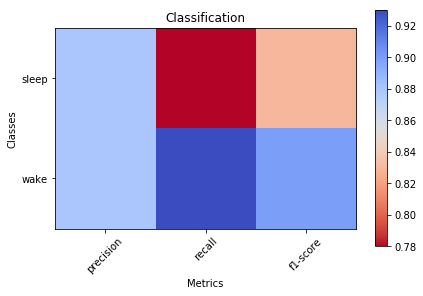

In [22]:
r = hp.run_flow(df, feature_list, 'sleep')
pr.plot_classification_report(r[1], cmap=plt.cm.coolwarm_r)

### 4B. For each user (SVM awake  x sleep)

In [ ]:
# which users have sleep data?
df.loc[df.sleep=='sleep'].user.unique()

In [ ]:
for user in [0, 1, 2, 4, 6]:
    hp.run_flow(df.loc[df.user == user], feature_list, 'sleep')